In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import (GradientBoostingRegressor, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              RandomForestClassifier)
from sklearn.metrics import log_loss, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from basis_expansions.basis_expansions import LinearSpline
import statsmodels.api as sm
from glm.glm import GLM
from glm.families import Gaussian
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from rfpimp import *

plt.style.use('ggplot')

%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

In [74]:
churn_data = pd.read_csv('data/churn_train.csv')
churn_data

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.00,5.00,1.00,Astapor,2014-05-03,Android,2014-01-12,0.00,0,False,100.00
1,8.06,5.00,5.00,1.00,Astapor,2014-01-26,Android,2014-01-25,0.00,2,True,0.00
2,21.50,4.00,nan,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.00,1,True,100.00
3,9.46,5.00,nan,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.00,1,False,100.00
4,13.77,5.00,nan,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.00,0,False,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2.06,4.80,4.30,1.08,Winterfell,2014-04-02,Android,2014-01-26,9.50,8,False,90.50
39996,2.05,5.00,5.00,1.00,King's Landing,2014-05-09,iPhone,2014-01-08,0.00,2,False,85.70
39997,3.04,5.00,5.00,1.00,Winterfell,2014-06-24,Android,2014-01-04,0.00,3,True,33.30
39998,3.49,4.30,3.30,1.50,Astapor,2014-02-09,iPhone,2014-01-08,40.00,5,False,60.00


In [3]:
def clean_data(data):
    data['avg_rating_by_driver'].fillna(np.mean(data['avg_rating_by_driver'][~data['avg_rating_by_driver'].isna()]), inplace=True)
    data['avg_rating_of_driver'].fillna(np.mean(data['avg_rating_of_driver'][~data['avg_rating_of_driver'].isna()]), inplace=True)
    data['phone'].fillna('Other', inplace=True)
    data['active_status'] = data['last_trip_date'].map(lambda x: int(x[5:7]) >= 6)
    dummy_city = pd.get_dummies(data['city'], drop_first=True)
    dummy_phone = pd.get_dummies(data['phone'])
    data = pd.concat([data, dummy_city, dummy_phone], axis=1)
    data.drop(columns=['city', 'phone', 'last_trip_date', 'signup_date', 'Other'], inplace=True)
    return data

In [4]:
churn_df = clean_data(churn_data)

In [5]:
churn_df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,active_status,King's Landing,Winterfell,Android,iPhone
0,6.94,5.00,5.00,1.00,0.00,0,False,100.00,False,0,0,1,0
1,8.06,5.00,5.00,1.00,0.00,2,True,0.00,False,0,0,1,0
2,21.50,4.00,4.60,1.00,0.00,1,True,100.00,False,0,1,0,1
3,9.46,5.00,4.60,2.75,100.00,1,False,100.00,False,0,1,1,0
4,13.77,5.00,4.60,1.00,0.00,0,False,100.00,False,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2.06,4.80,4.30,1.08,9.50,8,False,90.50,False,0,1,1,0
39996,2.05,5.00,5.00,1.00,0.00,2,False,85.70,False,1,0,0,1
39997,3.04,5.00,5.00,1.00,0.00,3,True,33.30,True,0,1,1,0
39998,3.49,4.30,3.30,1.50,40.00,5,False,60.00,False,0,0,0,1


In [6]:
y = churn_df['active_status']
X = churn_df.drop(columns='active_status')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
def feature_coefficients(model, X):
    cf = model.coef_
    Xf = X.columns
    result = list(zip(Xf, cf[0]))
    return sorted(result, key = lambda x: x[1])[::-1]

In [9]:
# Logistic Model

In [10]:
lg_model = LogisticRegression(solver='lbfgs', max_iter=500) # got warnings to change solver and increase iterations

In [11]:
lg_model.fit(X_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
lg_yprob = lg_model.predict_proba(X_test)
lg_ypred = lg_model.predict(X_test)

In [13]:
print(lg_model.score(X_train, y_train))
print(lg_model.score(X_test, y_test))

0.7207333333333333
0.7196


In [14]:
lg_coefs_test = feature_coefficients(lg_model, X_test)

In [15]:
lg_coefs_test # make active clear - 1 is active

[("King's Landing", 1.7319222775813954),
 ('luxury_car_user', 0.896001126532504),
 ('iPhone', 0.8534334355286668),
 ('Winterfell', 0.5121480855500439),
 ('trips_in_first_30_days', 0.12095667367662542),
 ('surge_pct', 0.003932267661813945),
 ('weekday_pct', -8.553992425201243e-05),
 ('avg_dist', -0.03857874651963222),
 ('avg_rating_of_driver', -0.06755582443189298),
 ('avg_rating_by_driver', -0.17199668467734108),
 ('avg_surge', -0.18952476361409717),
 ('Android', -0.24645112398866575)]

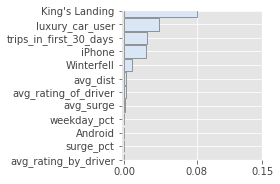

In [16]:
plot_importances(importances(lg_model, X_test, y_test)).view()

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, lg_ypred).ravel()
cnf_matrix = np.array([[tp,fn],[fp,tn]])
cnf_matrix

array([[1908, 1826],
       [ 978, 5288]])

In [18]:
print("Accuracy:", metrics.accuracy_score(y_test, lg_ypred))
print("Precision:", metrics.precision_score(y_test, lg_ypred))
print("Recall:", metrics.recall_score(y_test, lg_ypred))

Accuracy: 0.7196
Precision: 0.6611226611226612
Recall: 0.5109801821103375


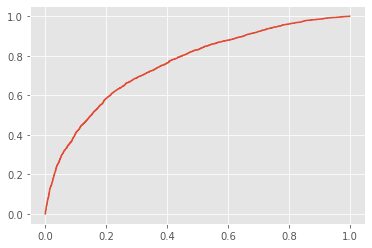

In [19]:
fpr, tpr, _ = metrics.roc_curve(y_test, lg_yprob[::,1])
plt.plot(fpr, tpr)

In [20]:
auc = metrics.roc_auc_score(y_test, lg_yprob[::,1])
auc

0.758922247423671

In [21]:
# Decision Tree Model

In [22]:
onetree = tree.DecisionTreeClassifier()

In [23]:
onetree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [24]:
print(onetree.score(X_train, y_train))
print(onetree.score(X_test, y_test))

0.9975333333333334
0.702


In [25]:
print(onetree.get_depth())
print(onetree.get_n_leaves())

55
7198


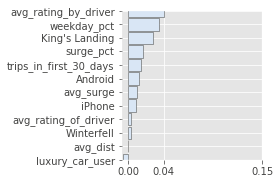

In [26]:
plot_importances(importances(onetree, X_test, y_test)).view()

In [27]:
# Random Forest Model

In [67]:
rf_model = RandomForestClassifier(n_estimators=100, oob_score=True)

In [68]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [69]:
print(rf_model.score(X_train, y_train))
print(rf_model.score(X_test, y_test))

0.9974
0.7545


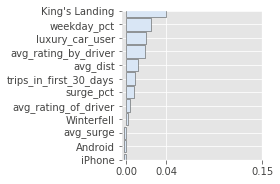

In [31]:
plot_importances(importances(rf_model, X_test, y_test)).view()

In [32]:
# Gradient Boosting Classifier

In [73]:
gblg_model = GradientBoostingClassifier(n_estimators=1000, min_samples_leaf=15)

In [34]:
gblg_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=15, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [35]:
print(gblg_model.score(X_train, y_train))
print(gblg_model.score(X_test, y_test))

0.8187
0.788


- n_estimators=100:
    - Train: 0.7917
    - Test: 0.7883
- n_estimators=1000, min_samples_leaf=15:
    - Train: 0.8183333333333334
    - Test: 0.7905

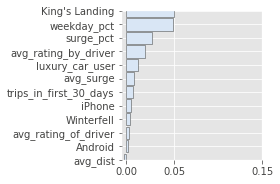

In [36]:
plot_importances(importances(gblg_model, X_test, y_test)).view()

In [37]:
# ADA Boost

In [38]:
ada_model = GradientBoostingClassifier(loss='exponential', n_estimators=1000, min_samples_leaf=15)

In [39]:
ada_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=15, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [40]:
print(ada_model.score(X_train, y_train))
print(ada_model.score(X_test, y_test))

0.8141
0.7854


- n_estimators=100:
    - Train: 0.7919333333333334
    - Test: 0.7893
- n_estimators=1000, min_samples_leaf=15:
    - Train: 0.8143333333333334
    - Test: 0.7903

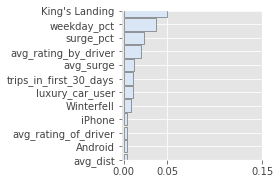

In [41]:
plot_importances(importances(ada_model, X_test, y_test)).view()

In [42]:
# Let's try the testing data!!

In [43]:
churn_test = pd.read_csv('data/churn_test.csv')
churnt_df = clean_data(churn_test)
yt = churnt_df['active_status']
Xt = churnt_df.drop(columns='active_status')
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt)

In [54]:
print(lg_model.score(Xt_train, yt_train))
print(lg_model.score(Xt_test, yt_test))
print(lg_model.score(Xt, yt))

0.7034666666666667
0.7172
0.7069


In [58]:
lgt_yprob = lg_model.predict_proba(Xt)
lgt_ypred = lg_model.predict(Xt)
tn, fp, fn, tp = confusion_matrix(yt, lgt_ypred).ravel()
cnf_matrix = np.array([[tp,fn],[fp,tn]])
cnf_matrix

array([[1830, 1942],
       [ 989, 5239]])

In [60]:
print("Accuracy:", metrics.accuracy_score(yt, lgt_ypred))
print("Precision:", metrics.precision_score(yt, lgt_ypred))
print("Recall:", metrics.recall_score(yt, lgt_ypred))

Accuracy: 0.7069
Precision: 0.6491663710535651
Recall: 0.4851537645811241


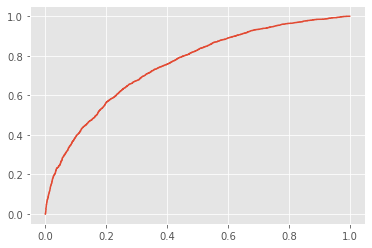

In [61]:
fpr, tpr, _ = metrics.roc_curve(yt, lgt_yprob[::,1])
plt.plot(fpr, tpr)

In [62]:
auc = metrics.roc_auc_score(yt, lgt_yprob[::,1])
auc

0.7547789214854954

In [55]:
print(onetree.score(Xt_train, yt_train))
print(onetree.score(Xt_test, yt_test))
print(onetree.score(Xt, yt))

0.706
0.7028
0.7052


In [71]:
print(rf_model.score(Xt_train, yt_train))
print(rf_model.score(Xt_test, yt_test))
print(rf_model.score(Xt, yt))

0.7482666666666666
0.7572
0.7505


In [70]:
print(gblg_model.score(Xt_train, yt_train))
print(gblg_model.score(Xt_test, yt_test))
print(gblg_model.score(Xt, yt))

0.7885333333333333
0.7888
0.7886


In [57]:
print(ada_model.score(Xt_train, yt_train))
print(ada_model.score(Xt_test, yt_test))
print(ada_model.score(Xt, yt))

0.786
0.7864
0.7861


In [63]:
# grid search attempt

In [64]:
from sklearn.model_selection import RandomizedSearchCV

In [66]:
model = GradientBoostingClassifier()

depth_parm = np.arange(1, 12, 1)
num_samples_parm = np.arange(5, 95, 10)
parameters = {'max_depth' : depth_parm,
             'min_samples_leaf' : num_samples_parm}
scorer = make_scorer(log_loss,
                     greater_is_better=False,
                     needs_proba=True)
clf = RandomizedSearchCV(model,
                   parameters,
                   cv=10,
                   scoring=scorer, n_jobs=-1)
clf.fit(X_train,y_train)
print(f"log loss = {-clf.score(X_test, y_test):.3f}")
print(f"accuracy = {(clf.predict(X_test) == y_test).mean():.3f}")

log loss = 0.452
accuracy = 0.787


### Gradient Boosting Classifier model worked best; with the information found, what are some suggestions to make on improving driver retention?

- Provide initiative for weekend drivers to try out weekday driving
- Create better screening for drivers
- Provide initiative at end of first-30-days mark
- Improve iPhone app